## Table of Contents
-   [ Notes](#1)
-   [ Required Packages](#2)
- [1 - PREPARE FOR PROCESSING](#preProcess)
- [2 - Calibrate values for the batch](#calibrate)
- [3 - Determine horizontal board disposition](#disposition)
- [4 - Identify and split boards sections.](#split)
- [5 - Validate Model and Label topBoards.](#validate)
- [4 - Identify and split boards sections.](#split)

    - [Exercise 3 - initialize_velocity](#ex-3)
    - [Exercise 4 - update_parameters_with_momentum](#ex-4)


<a name='1'></a>
# Notes from the Candidate.

I would like to first 

# CameraTop Assignment


We would like to segment all the elements: we have 9 topboards (in vertical on the image) and 3 connection boards (in horizontal on the image). 
*	What strategies do you propose?
*	Please note that some element could be missing. This should not affect to the element numbering (you could implement the numbering using different colors for each different board, for example).
*	Note also that there are three possible types of Top Deck Configuration. Please check attached document 'B4840A Top Deck Configurations.pdf' for details.
*	Please find attached Images from the three types of configurations.
*	It’s important to show some results images.
<br>



###  <font color='default' > Notes on the project.

<p><font  face="Times New Roman"> <font color='grey' > There are multiple paths we could take to arrive to the final board segmentation and the model identification. Although each way will consume different amounts of resources like memory or processing time... In our case, I don't believe realtime processing is a priority, so I will not be looking to minimize it, I will however keep it inside a reasonable contrain. Memory on the other hand, I will deal with the problem as if we had a long list of images to be processed (therefore, a workload instead of realtime) and we intent to create multiple worker threads to do follow this process with parallel processing.

<br>Another note, deep learning could be applied to a problem like this for faster results under (hopefully) the same or better performance. For that matter we would require ground truth extraction which we can get by the approach we are about to take. So I find it interesting to follow up with deeplearning after we finish with our traditional approach.

<br>Finally, I will generate some extreme cases, a broken board, a board missing great part of its surface... And look into some results and either determine a behaviour or theorize it.
</p>
TODO >>  ADD EXTREME IMAGES




DELETE THIS

Gradient descent goes "downhill" on a cost function $J$. Think of it as trying to do this: 
<img src="images/cost.jpg" style="width:650px;height:300px;">
<caption><center> <u> <b>Figure 1</b> </u>: <b>Minimizing the cost is like finding the lowest point in a hilly landscape</b><br> At each step of the training, you update your parameters following a certain direction to try to get to the lowest possible point. </center></caption>

**Notations**: As usual, $\frac{\partial J}{\partial a } = $ `da` for any variable `a`.

Let's get started!

<a name='2'></a>
## - Packages and Globals

We load known packages to be used in this demostration and define some global variables.

In [62]:


import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import SupportFunctions as mySF
from sklearn.cluster import KMeans
from collections import namedtuple

# path to the images
TOP_IMAGES_PATH = "./camera_top"
GREY_CALIB_IMAGES_PATH = "./greyLevelCalib"

# board information
length_units = 48000
height_units = 40000
LargeBoard = 5500
mediumBoard = 3500
mtoLBoardRatio = LargeBoard / mediumBoard
space_model_A = 1083
space_model_B = 1417
space_model_C = 1750


em = 4 # not found
eL = 3 # Combined board
L = 2 # large board
m = 1 # medium board
s = 0 # space


expected_nof_boards = 9
# sequence_model_A = [L,L,s,m,s,m,s,L,s,m,s,m,s,L,L]
# sequence_model_B = [L,L,s,m,s,m,s,m,s,m,s,m,s,L,L]
# sequence_model_C = [L,m,s,m,s,m,s,L,s,m,s,m,s,m,L]

sequence_model_A = [L,L,m,m,L,m,m,L,L]
sequence_model_B = [L,L,m,m,m,m,m,L,L]
sequence_model_C = [L,m,m,m,L,m,m,m,L]

# RATEs to be used later when deciding on models and boards
spaceToFullBoardRatioModelA = length_units/space_model_A
spaceToFullBoardRatioModelB = length_units/space_model_B
spaceToFullBoardRatioModelC = length_units/space_model_C

spaces_models =[spaceToFullBoardRatioModelA,spaceToFullBoardRatioModelB,spaceToFullBoardRatioModelC]
sequence_models =[sequence_model_A,sequence_model_B,sequence_model_C]
model_index = ['A','B','C']

LargeBoardToFullBoardRatio = length_units/LargeBoard
mediumBoardToFullBoardRatio = length_units/mediumBoard




<a name='preProcess'></a>
## 1 - PREPARE FOR PROCESSING

This step implies going from a Uint16 matrix to a one that will be more managable, and the image will be ready for the cleanest and fastest extraction of information.


### Possible steps to take:
<a name='ex-1'></a>
* Verify the board alignment. If the board is somehow angled, we must find out and correct it.
<b>Seems to have been corrected already</b>, so we will skip it for the time being). This will be validated when we observe the histograms in the upcomming steps. 
<br></br>


* For the topBoard check does not seem necessary to keep al the bit information of the uint16 matrix we have.
The regular uint8 should speed up the calculations without missing on information. Again, when detecting scratch and or other damage, this information will probably be much more handy.<br>Additionally, we will normallize the image to make the information more easily observable.<br><br>

* Prepare information regarding different boards, like width. Also, identify the spacing and disposition of elements regarding all 3 possible top-board variations. <br></br>






<Figure size 432x288 with 0 Axes>

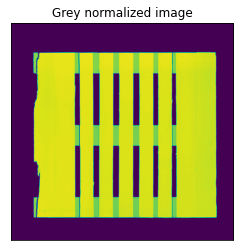

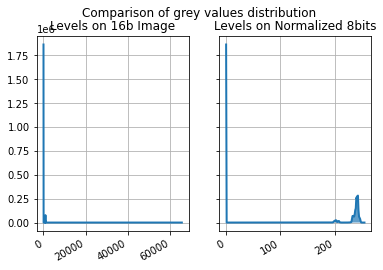

In [63]:

#   
def Convert8bAndNormalize ( image16b ):
    normalized = cv.normalize(image16b,None,0,65535,cv.NORM_MINMAX)
    return cv.convertScaleAbs(normalized,alpha=(255.0/65535.0))
    

###############     execution part      ############

image16 = mySF.load_image_from_folder_byIndex(TOP_IMAGES_PATH,1)
hist_values = cv.calcHist([image16.flatten()],channels=[0],mask=None,histSize=[65535],ranges=[0,65535])

# load up some sample financial data

image8bNorm = Convert8bAndNormalize ( image16 )
hist_values_norm = cv.calcHist([image8bNorm.flatten()],channels=[0],mask=None,histSize=[256],ranges=[0,255])

# mySF.getRectangle(image8bNorm)
# board = mySF.find_board(image8bNorm)
# imageCOL= cv.cvtColor(image8bNorm, cv.COLOR_GRAY2BGR);
# contours, hierarchy = cv.findContours(image8bNorm, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# create two subplots with the shared x and y axes
plt.figure (1)


# cosmeti display of information
fig, (ax0) = plt.subplots(1, 1)
# imageCOL = cv.drawContours(imageCOL, board, -1, (0, 255, 0),10)
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
ax0.imshow(image8bNorm)
ax0.set_title('Grey normalized image')

fig1, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True)

ax2.fill_between(range(0,256), min(hist_values_norm[:,0]),hist_values_norm[:,0],alpha=0.7)
ax2.plot(range(0,256),hist_values_norm,lw = 2)

ax1.plot(range(0,65535),hist_values, lw = 2)

ax1.set_title('Levels on 16b Image')
ax2.set_title('Levels on Normalized 8bits')

for ax in ax1, ax2:
    ax.grid(True)

for label in ax2.get_yticklabels():
    label.set_visible(False)

fig1.suptitle('Comparison of grey values distribution')
fig1.autofmt_xdate()



<a name ="calibrate"></a>
## 2 - Calibrate values for the batch

Before further explanation, we will not explain any calibration to be done to the camera according to its param. This should have been done before beggining this process.

Here we will extract values to be used when we process the different images. We are working under the asumption that the boards to be examined would have been taken by the same camera and are one of the 3 listed board models. This means that the depth maps will be similar going from one image to another.

### Determine greyLevel range that represents the top boards.

In this case we have the advantage that we know there will be 3 distinguised depth levels present in the images, with those being the background, bottom and top boards. I have selected a couple of the images I was given to create a 'calibrationSamples' where I store <b>known and good</b> samples from which to extract the greylevels. 

This is a process to set up thresholds before starting the process in each of the given images. We could either combine all the images into the same data stream, but in case that the camera view changes slightly, I choose to get the cluster center values for each image and average each corresponding depth level (each cluster's center). <br>

##### Note: this process should be done only once.

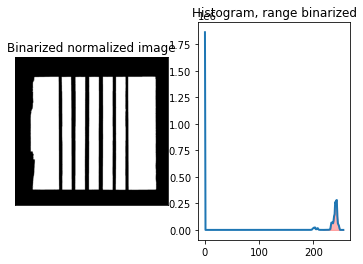

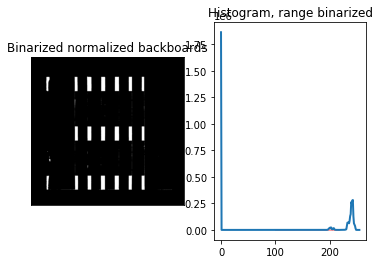

In [64]:
calib_images = mySF.load_images_from_folder(GREY_CALIB_IMAGES_PATH)


# will return 3 values indicating the depth of [bg, middleboards,topboards]
def getDepthLayersCenters(images, nof_clusters = 3):
    
    arr_ = []
    # cluster model
    
    scale_percent = 30
    #kmeans = blobs.KMeans(n_clusters=3, init='k-means++', random_state=0, max_iter=1)
    for ima in images:
        image8bNorm = Convert8bAndNormalize ( ima ) 
        width = int(image8bNorm.shape[1] * scale_percent / 100)
        height = int(image8bNorm.shape[0] * scale_percent / 100)
        dim = (width, height)
  
        # resize image to a 30% the original slcale
        resized = cv.resize(image8bNorm, dim)
        
        # validate not null - skipped
        arr_flatten = resized.flatten()
        kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0, max_iter=1)
        kmeans.fit(arr_flatten.reshape(-1,1)) 
        arr_.append(sorted(np.array(kmeans.cluster_centers_)))
        
        
    # convert from list to array    
    arr_ = np.array(arr_)

    
    nof_images = np.array(arr_).shape[0]
    nof_centers = np.array(arr_).shape[1]
    
    avr_centers = np.sum(arr_,axis=0)/nof_images

    # round and return
    return np.rint(sorted(avr_centers))


def median_value(val1, val2):
    threshold = np.rint((val1+val2)/2)
    threshold = int(threshold)
    return threshold

def getLayerByGreyRange(image, minTH, maxTH):
    
    #  th, im_th = cv.threshold(image, minTH, maxTH, cv.THRESH_BINARY)
    
    im_th = cv.inRange(image, minTH, maxTH)

    return im_th


def get2DepthLayers(image8bNorm_, cluster_c, verbose_ = False):
    
    # top boards layer
    threshold = median_value(cluster_c[1],cluster_c[2])
    max_threshold = 255 # till whitest white

    # Get binarized image of the layer
    imageTopTH = getLayerByGreyRange(image8bNorm_, threshold, max_threshold)

    if(verbose_):
        fig1, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False) 

        ax1.set_title('Binarized normalized image')
        ax2.set_title('Histogram, range binarized')

        ax1.get_yaxis().set_visible(False)
        ax1.get_xaxis().set_visible(False)
        ax1.imshow(imageTopTH,cmap='gray')
        
        where_b = np.zeros(256)
        for i in range(threshold,256) : where_b[i] = True; 
            
        ax2.fill_between(range(0,256), 0,hist_values_norm[:,0],alpha=0.3, where = where_b , color= "red")
        ax2.plot(range(0,256),hist_values_norm,lw = 2)



    ## Same for the boards in the second layer 
    threshold = median_value(cluster_c[0],cluster_c[1])
    max_threshold = median_value(cluster_c[1],cluster_c[2])

    # Get binarized image of the layer
    imageTHback = getLayerByGreyRange(image8bNorm_, threshold, max_threshold)
    
    if(verbose_):
        fig2, (ax3, ax4) = plt.subplots(1, 2, sharex=False, sharey=False)

        ax3.set_title('Binarized normalized backboards')
        ax4.set_title('Histogram, range binarized')

        ax3.get_yaxis().set_visible(False)
        ax3.get_xaxis().set_visible(False)
        ax3.imshow(imageTHback,cmap='gray')

        where_b = np.zeros(256)
        for i in range(threshold,max_threshold) : where_b[i] = True; 
            

        ax4.fill_between(range(0,256), 0,hist_values_norm[:,0],alpha=0.3, where = where_b , color= "red")
        ax4.plot(range(0,256),hist_values_norm,lw = 2)
    
    return imageTopTH,imageTHback

###############     execution part      ############

# We must run calibration at least once
clusters_centers = getDepthLayersCenters(calib_images)

# we will determine the binarization threshold for top boards, in this case we will just use the median values between centers
# though some kind of weighted average would have been better, but this median will sufice
imageTopTH, imageMidTH = get2DepthLayers(image8bNorm, clusters_centers,True)







## Determine horizontal board disposition
<a name ="disposition"></a>
Now that we have binarized the boards, we can easilly find out the horizontal space they occuppy and their disposition based on that area.

<br> For this purpose we will project the value on the columns into the horizontal space, creating a histogram of frequencies. Since the top-board has been aligned, this will easilly distinguish what space are the top boards ocuppying and which parts are empty. We also must take into account that the sides are made of joined boards, althought they will always be joined (unless by some defect they aren't...)

<br> Then, since we know the total dimensions of the whole structure, we can estimate measures and asociate this view to one of the 3 known models. There are multiple ways about it, like aligning the area with a premade mask 



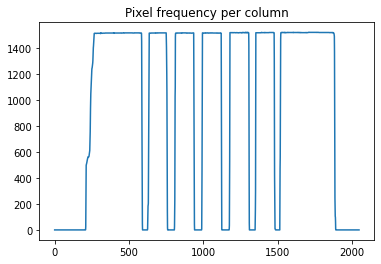

The board and space sequence (true = boards, false = space):
True - length:376 range: 213 - 588
False - length:43 range: 589 - 631
True - length:125 range: 632 - 756
False - length:52 range: 757 - 808
True - length:130 range: 809 - 938
False - length:53 range: 939 - 991
True - length:131 range: 992 - 1122
False - length:54 range: 1123 - 1176
True - length:131 range: 1177 - 1307
False - length:44 range: 1308 - 1351
True - length:127 range: 1352 - 1478
False - length:38 range: 1479 - 1516
True - length:368 range: 1517 - 1884
The horizontal range from where the board has been discovered is:
213 1884


In [65]:


########

# Step, measure each block
# Estimate beginning and end of board, also for each board.
# By measuring each board, and space ratio. Asing a letter to the 
# Resolve combined boards... this should be a matter of measuring spaces and/or board disposition

####

class BinarySegment:
    def __init__(self, type_, nof_conse_entries_):
        self.nof_conse_entries= nof_conse_entries_
        self.type = type_
        self.fromCol = -1
        self.toCol = -1
    
    def printSequence(self):
        print(str(bool(self.type)) + " - length:" + str(int(self.nof_conse_entries)) + " range: "+ str(int(self.fromCol)) + " - " + str(int(self.toCol)))

    def getLength(self):
        if(self.toCol == -1 or self.fromCol == -1):
            return -1
        
        return self.toCol - self.fromCol
    
    def getCenter(self):
        if(self.toCol == -1 or self.fromCol == -1):
            return -1
        return (self.toCol + self.fromCol)/2
    
        
class BoardSequence:
    def __init__(self):
        self.begins  = -1
        self.ends = -1  
        self.sequence = [] 
        self.symbolSequence = []
        self.symbolExpectedSequence = []
        # self.lengthsSequence =[]
        self.costSequence =[]
        self.total_lenght = -1
        self.avr_space_length = -1
        
    def getFullBoardWidth(self):
        self.total_lenght = int(self.sequence[len(self.sequence)-1].toCol) - int(self.sequence[0].fromCol)
        return self.total_lenght
    
    def getAverageSpaceLenght(self):
        """[Gets the average value of  spaces in a sequence object. Also returns 
        estimated number of missing boards]

        """
        # spaces = []
        acc_spaces = 0
        nof_spaces = 0
        nof_missing = 0

        
        for i in range(1,len(self.sequence)-1):
                
            if(self.sequence[i].type == False):
                slenght= self.sequence[i].getLength()
                acc_spaces += slenght
                #spaces.append(sequence[i])
                nof_spaces += 1
        
        self.avr_space_length = acc_spaces/nof_spaces
        return   self.avr_space_length
    
    

def getBoardSpaceSequence(image_acc_columns,acc_th):
    
    # if image_acc_columns == None:
    #     return 
    
    theSequence = BoardSequence()
    begins  = -1
    ends = -1  
    
    # image_acc_columns = np.sum(imageTHnorm,axis=0)
    currentSegment = BinarySegment(False,-1)
    isFilledRow = False
    currentSegment.type = False
    index = 0
    for i in image_acc_columns:

        if(i >= acc_th): 
            isFilledRow = True
            if(begins == -1):
                begins = index
            else:
                ends = index
            
            
        else:
            isFilledRow = False
            
        # first time
        if(currentSegment.nof_conse_entries == -1):
            currentSegment.fromCol = index
            currentSegment.nof_conse_entries = 0
            currentSegment.type = isFilledRow
        
        
        if(isFilledRow == currentSegment.type):
            # case we are about to alternate
            currentSegment.nof_conse_entries +=1
            currentSegment.toCol = index
        
        else:
            theSequence.sequence.append(currentSegment)
            currentSegment = BinarySegment(isFilledRow,1)
            currentSegment.fromCol = index

        index += 1
            
    theSequence.begins = begins
    theSequence.ends = ends           
    # append the last sequence
    theSequence.sequence.append(currentSegment)
    
    # lets get rid of the left and right empty space
    theSequence.sequence.pop()      # last
    theSequence.sequence.pop(0)     # first
    
    return theSequence


def CheckHorizontalDisposition(imageTH_, verbose_ =False):
    image_y = imageTH_.shape[0]
    image_x = imageTH_.shape[1]
    acc_th = np.rint(image_y/4)

    imageTHnorm = np.rint(imageTH_/imageTH_.max())
    image_acc_columns = imageTHnorm.sum(axis =0)
    theSequence = getBoardSpaceSequence(image_acc_columns,acc_th)
    
    
    # display value acc
    if verbose_:
        plt.plot(range(0,image_x),image_acc_columns)
        plt.title("Pixel frequency per column")
        plt.show()
    
    return theSequence


############# Execution #############



theSequence = CheckHorizontalDisposition(imageTopTH,True)

print("The board and space sequence (true = boards, false = space):")
for s in theSequence.sequence: s.printSequence()

print("The horizontal range from where the board has been discovered is:")

print(theSequence.begins,theSequence.ends)


# ax1.show()

## Identify and split boards sections.
<a name ="split"></a>
I must mention that there are many, many ways to tackle this problem. We must first be aware of how many boards are we dealing with. We expect that we would be mostly getting 7 segments, however, we should be ready to deal with either 7 or 8. This would normally mean that the combined boards appear splitted.
It could also mean that a board was broken, in this kind of scenarios we should report an error.

<br>
Spaces should be consistent across the whole board, meaning that each should have a similar size. In any other scenario,




In [66]:



# Normally this would be part of the object sequence, but I'm splitting it for segmeting my explanations
def sequentialize(thesequence):
    """[Analized the different regions tagged in a sequence object. Based on known relativa lenghts to the board lenght,
        returns the estimated BoardType sequence, also missing spaces, their distances and costs in respective lists]

    """

    total_lenght = thesequence.getFullBoardWidth()
    avr_space_length = thesequence.getAverageSpaceLenght()
    
    expectedMediumLenght = total_lenght/mediumBoardToFullBoardRatio
    expectedLargeLength = total_lenght/LargeBoardToFullBoardRatio
    
    expectedCombinedLm = expectedLargeLength + expectedMediumLenght
    expectedCombinedLL = 2*expectedLargeLength
    expectedMissingBoardL = expectedLargeLength + (int)(2*avr_space_length)
    expectedMissingBoardm = expectedMediumLenght + (int)(2*avr_space_length)
    expectedMissingGapTooLarge = expectedCombinedLm + (int)(2*avr_space_length)
    large_boards_found = 0
    
    for i in range(len(thesequence.sequence)):
        seglenght= thesequence.sequence[i].getLength()
        if(thesequence.sequence[i].type == True):

            #scenario one, combined boards
            # a way to detect combined boards
            if(seglenght > 2*expectedMediumLenght) :
                
                if(abs(expectedCombinedLL-seglenght) <abs(expectedCombinedLm-seglenght)):
                    # closer to L L
                    thesequence.costSequence.append(abs(expectedCombinedLL-seglenght))
                    thesequence.symbolSequence.append('LL')
                    theSequence.symbolExpectedSequence.append(L)
                    theSequence.symbolExpectedSequence.append(L)

                    large_boards_found+=1
                    
                    # there are surely more elegant ways about this, but
                else:
                    thesequence.costSequence.append(abs(expectedCombinedLm-seglenght))
                    # lengthsSequence.append(seglenght)
                    large_boards_found+=1
                    # closer to L L
                    if(i == 0):
                        thesequence.symbolSequence.append('Lm')
                        theSequence.symbolExpectedSequence.append(L)
                        theSequence.symbolExpectedSequence.append(m)
                    elif(i == len(thesequence.sequence)-1):
                        thesequence.symbolSequence.append('mL')
                        theSequence.symbolExpectedSequence.append(m)
                        theSequence.symbolExpectedSequence.append(L)
                        
                    else:
                        print("ERROR, detected combine where it should not be posible, at position in sequence: "+ str(i))
                        # return -1,-1
            # large boards
            elif(abs(expectedLargeLength-seglenght) < abs(expectedMediumLenght-seglenght)):
                thesequence.costSequence.append(abs(expectedLargeLength-seglenght))
                # lengthsSequence.append(seglenght)
                thesequence.symbolSequence.append('L')
                theSequence.symbolExpectedSequence.append(L)
            else:
                
                thesequence.costSequence.append(abs(expectedMediumLenght-seglenght))
                # lengthsSequence.append(seglenght)
                thesequence.symbolSequence.append('m')
                theSequence.symbolExpectedSequence.append(m)
                
            # if is the first scenario
        
        # this means a board is missing, the space is too large
        elif (thesequence.sequence[i].type == False and thesequence.sequence[i].getLength() > expectedMediumLenght):
            # this is a rough estimate to find how many boards might be missing
            # based on the number of boards identified, we can later decide even if just a single n was inserted
            # we could also introduce multiple n's but it might be harder to determine how many before all boards 
            # have been dealt with
            
                # expectedMissingBoardL = expectedLargeLength + (int)(2*avr_space_length)
                # expectedMissingBoardm = expectedMediumLenght + (int)(2*avr_space_length)
                # expectedMissingGapTooLarge = expectedCombinedLm + (int)(2*avr_space_length)
            
            
            if(seglenght > expectedMissingGapTooLarge):
                print("ERROR, Board is missing multiple boards... deemed unsafe... "+ str(i))
                thesequence.symbolSequence.append('n')
                # return -1        
            elif(abs(expectedMissingBoardL-seglenght) < abs(expectedMissingBoardm-seglenght)):
                thesequence.symbolSequence.append('eL')
                theSequence.symbolExpectedSequence.append(L)
            else:
                thesequence.symbolSequence.append('em')
                theSequence.symbolExpectedSequence.append(m)
                
        elif(thesequence.sequence[i].type == False):
            thesequence.symbolSequence.append('s')
            
            
    return 
    
    


    


##############  Execution    ###############  



# total_lenght = getFullBoardWidth(sequence)
# avr_space, nof_missing = getAverageSpace(sequence)

sequentialize(theSequence)

spaceToFullBoardRatio = theSequence.total_lenght
avr_space_ratio = theSequence.avr_space_length
print (theSequence.symbolSequence)
print (theSequence.symbolExpectedSequence)



['LL', 's', 'm', 's', 'm', 's', 'm', 's', 'm', 's', 'm', 's', 'LL']
[2, 2, 1, 1, 1, 1, 1, 2, 2]


## Validate Model and Label topBoards
<a name ="validate"></a>
Now we have a sequence that should be robust to find missing tabloids. There are some scenarios where we probably will be missing informations, but my algorithms should satisfy this challenge's requirements. One of the requirements is to identify each board even in the possibility of a missing element. We can trust that our sequence will be accurate while we are not missing more than 2 consecutive boards. I would suggest marking these boards for revision in this case.


### Deciding the model.
We can trust in two 



In [75]:

mycolors = [
    [10,10,200],
    [200,10,10],
    [10,200,10],
    [200,10,200],
    [10,200,200],
    [200,200,10],
    [100,10,200],
    [10,100,200],
    [100,100,10]]    
 

#  expected_nof_boards = 9
# sequence_model_A = [L,L,s,m,s,m,s,L,s,m,s,m,s,L,L]
# sequence_model_B = [L,L,s,m,s,m,s,m,s,m,s,m,s,L,L]
# sequence_model_C = [L,m,s,m,s,m,s,L,s,m,s,m,s,m,L]
sequence_models =[sequence_model_A,sequence_model_B,sequence_model_C]


def getMatchingModel(theSequence, display = False):
        if(len(theSequence.symbolExpectedSequence) != expected_nof_boards):
            if(display):print("Unknown Model")
            return None
        
        for i in range(len(sequence_models)):
            fit = True
            for j in range(len(theSequence.symbolExpectedSequence)):
                if (sequence_models[i][j] != theSequence.symbolExpectedSequence[j]):
                    fit =False
                    break
            if(fit): 
                print(model_index[i])
                return model_index[i]
            
        if(display):print("Unknown Model")
        return None 
                
    

# # This function would be part of the sequence object but I prefer to split my code in blocks for better display and exposition
def DisplayBoardDisposition(theSequence):
    
    
    def isFilledArea(code):
        if(code == 'L' or code == 'm'):
            return 1
        elif(code == 'Lm' or code == 'mL' or code == 'LL'):
            return 2
        else:
            return 0
    
    boards =[]
    sequenceLenght = len(theSequence.sequence) 
    symbolsLenght = len(theSequence.symbolSequence)
    
    boardIndex = 0
    
    for i in range (symbolsLenght) :
        
        
        code = theSequence.symbolSequence[i]
        type = isFilledArea(code)
        # analyze board by board base on the stored type
        # case 2 this is a combined board
        if(type == 2):
            boardIndex += 1
            # LargeBoard = 5500
            # mediumBoard = 3500
            LargeToMediumRatio = LargeBoard/mediumBoard

            if (code == 'LL'):
                combinedLenght = theSequence.sequence[i].getLength()
                if(theSequence.sequence[i].fromCol - theSequence.avr_space_length/3 > 0):
                    left = theSequence.sequence[i].fromCol - theSequence.avr_space_length/3
                else: left = 0
                middle = theSequence.sequence[i].fromCol + combinedLenght - (1-1/2)*combinedLenght # check this
                # if(theSequence.sequence[i].toCol + theSequence.avr_space_length/3 > 0):
                right = theSequence.sequence[i].toCol + theSequence.avr_space_length/3 

            elif (code == 'Lm'):
                combinedLenght = theSequence.sequence[i].getLength()
                if(theSequence.sequence[i].fromCol - theSequence.avr_space_length/3 > 0):
                    left = theSequence.sequence[i].fromCol - theSequence.avr_space_length/3
                else: left = 0
                middle = theSequence.sequence[i].fromCol + combinedLenght - (1-1/LargeToMediumRatio)*combinedLenght # check this
                right = theSequence.sequence[i].toCol + theSequence.avr_space_length/3
                
            elif(code == 'mL'):
                combinedLenght = theSequence.sequence[i].getLength()
                # if(theSequence.sequence[i].toCol + theSequence.avr_space_length/3 > 0):
                right = theSequence.sequence[i].toCol + theSequence.avr_space_length/3  # there should be a check to verify that it does not go out of range
                # else: right = 0
                middle = theSequence.sequence[i].fromCol + combinedLenght - (1/LargeToMediumRatio)*combinedLenght # check this
                left = theSequence.sequence[i].fromCol - theSequence.avr_space_length/3 
            
            boards.append([int(left),int(middle)])
            boards.append([int(middle+1),int(right)])

        elif(type == 1):

            left = theSequence.sequence[i].fromCol - theSequence.avr_space_length/3
            right = theSequence.sequence[i].toCol + theSequence.avr_space_length/3
            
            boards.append([int(left),int(right)])
            
        # we skip these cases    
        else:
            if(code == 'em' or code == 'eL'):
                boards.append([-1,-1])
            
            
    return boards
            

            
        
def DrawBoards(imageTH, boards):
    image_x = imageTH.shape[1]
    image_y = imageTH.shape[0]
    colorImage = cv.cvtColor(imageTH, cv.COLOR_GRAY2BGR)
    # colorImage = np.zeros([image_x,image_y,3])
    
    for k in range (len(boards)): 
        if(boards[k][0] == -1 or boards[k][1] == -1):
            continue 
        for i in range(boards[k][0],boards[k][1]):
            for j in range(0,image_y):
                if(imageTH[j,i]):
                    colorImage[j,i]=mycolors[k]
                    
    # cosmeti display of information
    # fig2, (ax3, ax4) = plt.subplots(1, 2, sharex=False, sharey=False)


                  
    return colorImage
        
    
        
    


# def labelBoards(imageTH, sequence, sequenceLabels):
    
#     # we will run the container sequence


#############   Execution   #############

# output = cv.connectedComponentsWithStats(imageTopTH,)
getMatchingModel(theSequence, display = True)
# print(num_labels)
boards = DisplayBoardDisposition(theSequence)
print("Boards expected to ocuppy the following space in the image: ")
print (boards)

colorImage = DrawBoards(imageTopTH, boards)



C
Boards expected to ocuppy the following space in the image: 
[[193, 402], [403, 528], [550, 725], [757, 919], [934, 1165], [1176, 1341], [1364, 1527], [1531, 1667], [1668, 1892]]


<a name='ex-4'></a>   
### Demo on TOP_images folder:



B
B
C
A
C


<Figure size 432x288 with 0 Axes>

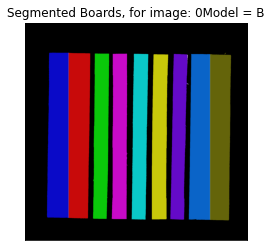

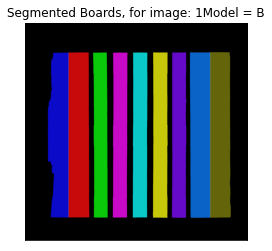

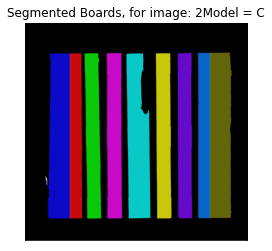

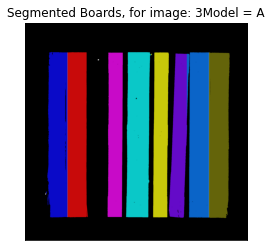

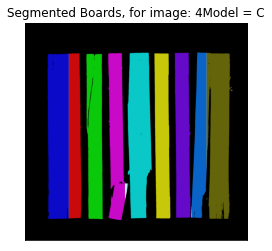

In [76]:
images = mySF.load_images_from_folder(TOP_IMAGES_PATH)

index = 0
for image in images:
    # hist_values = cv.calcHist([image16.flatten()],channels=[0],mask=None,histSize=[65535],ranges=[0,65535])
    image8bNorm = Convert8bAndNormalize ( image )
    # hist_values_norm = cv.calcHist([image8bNorm.flatten()],channels=[0],mask=None,histSize=[256],ranges=[0,255])
    
    imageTopTH, imageMidTH = get2DepthLayers(image8bNorm, clusters_centers)
    theSequence = CheckHorizontalDisposition(imageTopTH)
    
    sequentialize(theSequence)

    spaceToFullBoardRatio = theSequence.total_lenght
    avr_space_ratio = theSequence.avr_space_length
        
    model = getMatchingModel(theSequence)
    # print(num_labels)
    boards = DisplayBoardDisposition(theSequence)
    colorImage = DrawBoards(imageTopTH, boards)
    fig =plt.figure(index)
    
    fig, (ax0 ) = plt.subplots(1, 1)
    # imageCOL = cv.drawContours(imageCOL, board, -1, (0, 255, 0),10)
    # ax1.get_yaxis().set_visible(False)
    # ax1.get_xaxis().set_visible(False)
    # ax1.imshow(imageTH)
    # ax1.set_title('original')
    
    ax0.get_yaxis().set_visible(False)
    ax0.get_xaxis().set_visible(False)
    ax0.imshow(colorImage)
    ax0.set_title('Segmented Boards, for image: ' + str(index) + 'Model = '+ model)
    index +=1

